# Analyzing the courses in Coursera
## Introduction
Coursera is an amazing educational website that offers numerous online courses to students. I myself have completed few courses from it and was curious to see which were the most popular courses in the website.

## Objective
In this project I have scraped the data from the coursera website to gather the neccesary information for each course offered on the website. I have then applied machine learning tools to predict the completion percent for each course based on the information collected. Following questions will be answered from the analysis- <br>
1) Course with the highest enrollments. <br>
2) Course with highest ratings. <br>
3) Estimating the course with highest completion percents. <br>
4) Relationship between ratings and completion percent. <br>
5) Developing a predictive model about the completion percent. <br>

I tried to compare this data with other educational websites like Edx and Udacity. However Edx and Udacity do not show the rating for each course or the number of people who have rated it (atleast not that I am aware of).

In [471]:
# importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
from bs4 import BeautifulSoup
import re
import time

## Data Gathering
All the data is collected from https://www.coursera.org/search?query=& . However, since the data is spread across 100 pages, the URL is run in a loop to gather the information. 

I am collecting the course name, course type (certificate vs specialization etc), course difficulty, enrollments, ratings and the number of raters for each course. BeautrifulSoup is used to take data from HTML and regex expressions are used to search for information from the HTML script element.

The _for_ loop was put on sleep mode for few seconds after every iteration to prevent continuos request to the page.

In [559]:
# Splitting the URL into different parts to accomodate different pages on the website
URL_first= 'https://www.coursera.org/search?page='
URL_second= '&index=prod_all_products_term_optimization&allLanguages=English'
df= pd.DataFrame()

for i in range(1,70):
    URL= URL_first+str(i)+URL_second
    
    # Parsing the webpage using requests and BeautifulSoup
    r_catalog = requests.get(URL)
    soup_c= BeautifulSoup(r_catalog.content,'html.parser' )
    
    # Finding the data stored in the script HTML element
    temp =soup_c.find_all('script')[10].contents[0]
    
    # Number of raters
    num_raters = [int(x.split(':')[-1]) for x in re.findall('"numProductRatings":\d*', temp)]
    
    # Name of program
    program_name =[re.split('\"',x)[3] for x in re.findall('"name":[^\{\}]+,"partnerLogos"', temp)]
     
    # Number of Enrollments
    enroll = [int(x.split(':')[-1])for x in re.findall('"enrollments":\d*', temp)]
    
    # Difficulty level like Begineer, Mixed etc
    difficulty = [ x.split('"')[-2] for x in re.findall('"productDifficultyLevel":"[\w\s]*"', temp)]
    
    # Program Overall rating out of 5
    program_rating = [round(float(x.split(':')[-1]),2) for x in re.findall('"avgProductRating":\d*\.?\d*', temp)]
    
    # Program type like Specialization, Certification etc
    program_type = [x.split('"')[-2] for x in re.findall('"entityType":"[\w\s\w]*"', temp)]
    
    # List of Skills built 
    skill_list= [re.split('\:|\,"imageUrl"',x)[1]  for x in re.findall('"skills":[\[\w\s\"\,\]]*,"imageUrl"', temp)]
    
    # Offered by
    offer_by = [re.split('\"',x)[3] for x in re.findall('"partners":[^\{\}]+,"language"', temp)]
    
    #Making a dataframe with each lists
    df_temp = pd.DataFrame({'program_name':program_name,'difficulty':difficulty,'program_type':program_type,\
            'program_rating':program_rating,'num_raters':num_raters,'enroll':enroll, \
                          'offered_by':offer_by})
    
    if i==1:
        df = df_temp.copy()
        
    else:
        df= pd.concat((df,df_temp))
    
    # Pausing the next iteration for a few seconds
    time.sleep(np.random.randint(2,10))
    
df.shape

(2610, 7)

In [561]:
catalog_temp = df.copy()
catalog_temp.tail()

,program_name,difficulty,program_type,program_rating,num_raters,enroll,offered_by
85,"HTML, CSS, and Javascript for Web Developers",Mixed,COURSE,4.83,5814,223772,Johns Hopkins University
86,Improving your statistical inferences,Intermediate,COURSE,4.87,522,37326,Eindhoven University of Technology
87,Jazz Improvisation,Intermediate,COURSE,4.81,636,56784,Berklee College of Music
88,Blended Language Learning: Design and Practice...,Intermediate,COURSE,4.87,15,1560,University of Colorado Boulder
89,Disaster Preparedness,Beginner,COURSE,4.66,511,24409,University of Pittsburgh


In [563]:
# Concating all the pages with the catalog dataframe
catalog= pd.concat((catalog_temp, df.copy()))
catalog.shape

(8910, 7)

## Data Gathering
The collected data has lot of duplicate rows and needs to be checked for tidiness issue.

In [564]:
# Exploring the duplicates in the dataset
catalog.duplicated().sum()

7900

In [565]:
# Dropping the duplicate values
catalog.drop_duplicates(inplace= True)

catalog.duplicated().sum()

In [567]:
catalog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010 entries, 0 to 69
Data columns (total 7 columns):
program_name      1010 non-null object
difficulty        1010 non-null object
program_type      1010 non-null object
program_rating    1010 non-null float64
num_raters        1010 non-null int64
enroll            1010 non-null int64
offered_by        1010 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 63.1+ KB


In [680]:
# Checking for missing values
df.isna().sum()

program_name      0
difficulty        0
program_type      0
program_rating    0
num_raters        0
enroll            0
offered_by        0
dtype: int64

## Data Exploration
**1) Finding the most popluar courses by enrollment on Coursera**

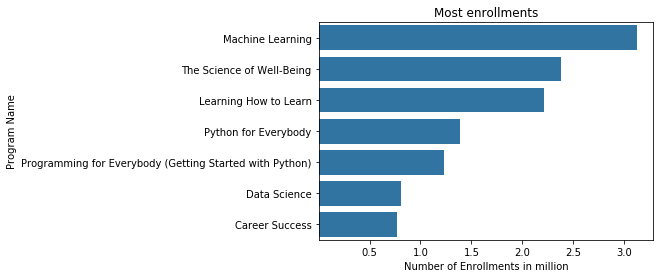

In [640]:
# Exploring the most popular courses by enrollment

a= catalog.sort_values(by='enroll', ascending= False, ).head(7)
sns.barplot(y = [re.split('\:',x)[0] for x in a.program_name], x= a.enroll,color= 'C0' , ci=0 ) 
plt.xticks(np.arange(500000,3100000,500000), np.arange(0.5,3.1,0.5))
plt.xlabel('Number of Enrollments in million')
plt.ylabel('Program Name')
plt.title('Most enrollments')
plt.show()

Machine Learning by Andrew Ng (Stanford) is the most popular course on coursera with more than 3 million enrollments followed by The Science of Wellbeing with approximately 2.2 million enrollments.

**2) Finding the highest rated course on Coursera** <br>
I have changed in the x-axis of the boxplot to highlight the small difference between the top rated courses.

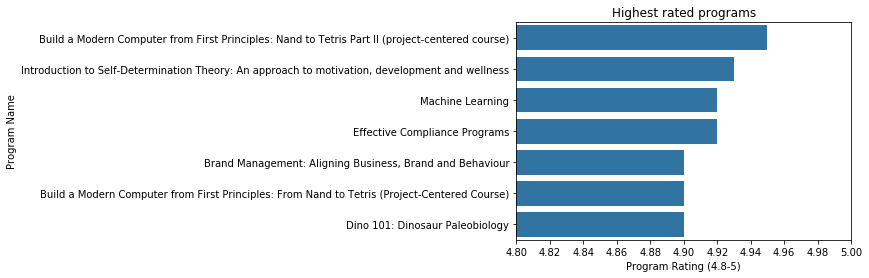

In [681]:
# Exploring the most popular courses by rating
b= catalog.sort_values(by='program_rating', ascending= False, ).head(7)
sns.barplot(y=b.program_name , x= b.program_rating, color= 'C0', ) #[re.split('\:',x)[0] for x in b.program_name]
plt.xlim(4.8,5,0.02)
plt.xticks(np.arange(4.8,5,0.02))
plt.xlabel('Program Rating (4.8-5)')
plt.ylabel('Program Name')
plt.title('Highest rated programs')
plt.show()

Build a Modern Computer is the highes rated course on Coursera with a rating of 4.94.

**3) Estimating completion percent** <br>
After each course is finished the website asks you to rate the course. Based on the number of people who rated the course I tried to find an estimate of the completion percent (number of ratings/ number of enrollments). This is a rough estimate as some people might not opt for rating the course after completion.  Hence, this is our best estimate for finding the completion percent.

For analyzing this data I have filtered the courses that have atleast 10,000 enrollments.

In [644]:
# Building a column for completion percent
catalog['completion_percent']= round((catalog.num_raters*100)/ catalog.enroll,1)
catalog.head()

,program_name,difficulty,program_type,program_rating,num_raters,enroll,offered_by,completion_percent
0,Introduction to Project Management,Beginner,RHYME PROJECT,4.45,108,1634,Rhyme,6.6
1,Spreadsheets for Beginners using Google Sheets,Beginner,RHYME PROJECT,4.71,116,1376,Rhyme,8.4
2,Introduction to Relational Database and SQL,Beginner,RHYME PROJECT,4.52,109,1397,Rhyme,7.8
3,Anomaly Detection in Time Series Data with Keras,Intermediate,RHYME PROJECT,4.54,13,379,Rhyme,3.4
4,Use Canva to Create Social Media Marketing Des...,Beginner,RHYME PROJECT,4.52,96,1372,Rhyme,7.0


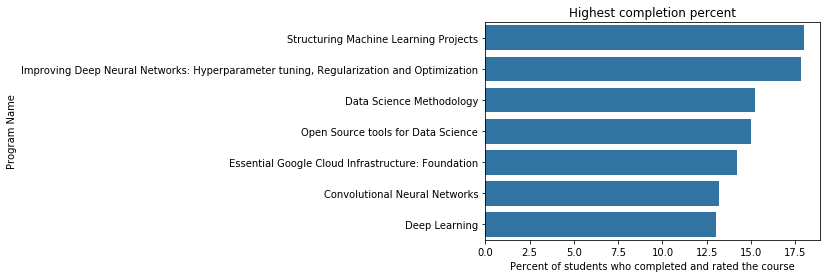

In [651]:
# Courses with highest percent completion that were enrolled by atleast 10,000 people
c= catalog.query('enroll>10000').sort_values(by='completion_percent', ascending= False, ).head(7)
sns.barplot(x= c.completion_percent, y= c.program_name, color= 'C0')
plt.xlabel('Percent of students who completed and rated the course')
plt.ylabel('Program Name')
plt.title('Highest completion percent')
plt.show()

Structuring Machine Learning Proejcts by deeplearning.ai is the course with one of the highest estimated completion percent ~17.5%.

**4) Organizations offering the most number of courses**

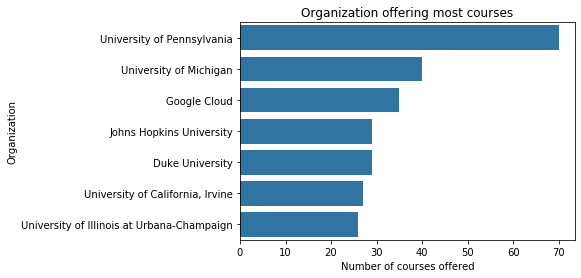

In [686]:
# Universities that offer the majority of the courses

sns.barplot(y= catalog.offered_by.value_counts().head(7).index, x= catalog.offered_by.value_counts().head(7), color= 'C0' )
plt.title('Organization offering most courses')
plt.ylabel('Organization')
plt.xlabel('Number of courses offered')
plt.show()

In [653]:
catalog.program_type.value_counts()

COURSE                      657
SPECIALIZATION              318
RHYME PROJECT                20
PROFESSIONAL CERTIFICATE     15
Name: program_type, dtype: int64

**5) Most popular specialization programs**
Specialization are a series of courses that help to specialize in a particular domain. <br>
Python for everybody seems to have the highest number of enrollments (approximately 1.4 million).

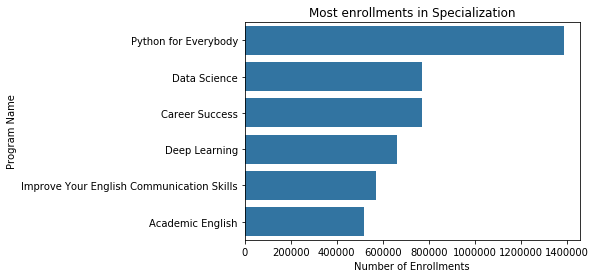

In [662]:
# Most popular specializations

a= catalog.query('program_type=="SPECIALIZATION"').sort_values(by='enroll', ascending= False).head(7)
sns.barplot(y = [re.split('\:',x)[0] for x in a.program_name], x= a.enroll,color= 'C0' , ci=0 ) 
plt.xlabel('Number of Enrollments')
plt.ylabel('Program Name')
plt.title('Most enrollments in Specialization')
plt.show()

**Correlation between completion percent and program rating**

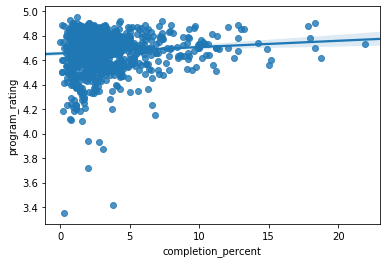

                    program_rating  num_raters    enroll  completion_percent
program_rating            1.000000    0.099278  0.089996            0.085864
num_raters                0.099278    1.000000  0.742498            0.409394
enroll                    0.089996    0.742498  1.000000            0.071807
completion_percent        0.085864    0.409394  0.071807            1.000000


In [755]:
#Scatterplot for ratings and enrollment relationship
sns.regplot( x= catalog.completion_percent, y= catalog.program_rating,  )
plt.show()
print(catalog.corr())

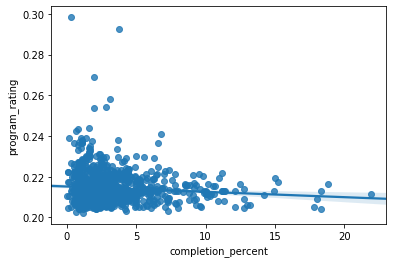

In [809]:
#Scatterplot for ratings and enrollment relationship with a Hyperbolic relationship
sns.regplot( x= catalog.completion_percent, y= 1/catalog.program_rating,  )
plt.show()

**5) Distribution of the program rating, enrollments and completion percent**

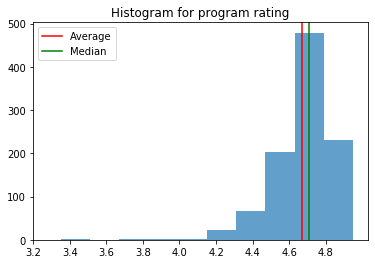

In [742]:
# Historgram for the program rating
plt.hist(catalog.program_rating, alpha= 0.7 )
plt.axvline(catalog.program_rating.mean(), color= 'r', label= 'Average')
plt.axvline(catalog.program_rating.median(), color= 'g', label= 'Median')
plt.xticks(np.arange(3.2,5,0.2))
plt.title('Histogram for program rating')
plt.legend()
plt.show()

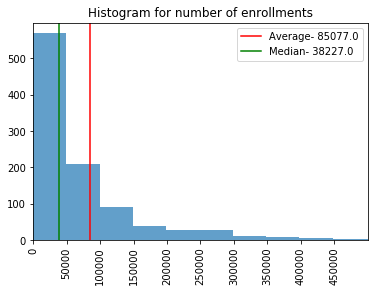

In [741]:
# Historgram for the number of enrollments

plt.hist(catalog.enroll,bins= 63, alpha= 0.7 )
plt.axvline(catalog.enroll.mean(), color= 'r', label= 'Average- '+ str(round(catalog.enroll.mean(),0)))
plt.axvline(catalog.enroll.median(), color= 'g', label= 'Median- '+ str(catalog.enroll.median()))

plt.xlim(0,500000)
plt.xticks(np.arange(0,500000,50000), rotation=90)
plt.title('Histogram for number of enrollments')
plt.legend()
plt.show()

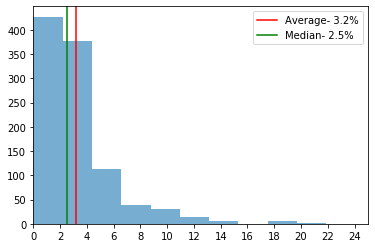

In [740]:
# Historgram for the completion percent
plt.hist(catalog.completion_percent, alpha= 0.6)
percent_mean = round(catalog.completion_percent.mean(),1)
plt.axvline(percent_mean, color= 'r', label= 'Average- '+ str(percent_mean) + '%')
percent_median= catalog.completion_percent.median()
plt.axvline(percent_median, color= 'g', label= 'Median- '+ str(percent_median)+ '%')
plt.xlim(0,25)
plt.xticks(np.arange(0,25,2))
plt.legend()
plt.show()

In [747]:
print('Completed by ',catalog.num_raters.sum(),' Enrolled by ', catalog.enroll.sum())

Completed by  3126286  Enrolled by  85927878


In [748]:
catalog.head()

,program_name,difficulty,program_type,program_rating,num_raters,enroll,offered_by,completion_percent
0,Introduction to Project Management,Beginner,RHYME PROJECT,4.45,108,1634,Rhyme,6.6
1,Spreadsheets for Beginners using Google Sheets,Beginner,RHYME PROJECT,4.71,116,1376,Rhyme,8.4
2,Introduction to Relational Database and SQL,Beginner,RHYME PROJECT,4.52,109,1397,Rhyme,7.8
3,Anomaly Detection in Time Series Data with Keras,Intermediate,RHYME PROJECT,4.54,13,379,Rhyme,3.4
4,Use Canva to Create Social Media Marketing Des...,Beginner,RHYME PROJECT,4.52,96,1372,Rhyme,7.0


## Predictive Analysis
We need to predict the completion rate of the course by the available information. <br>
Difficulty, program_type, offered by are all categorical columns and need to be one hot encoded.

In [765]:
# Getting the dummies for the categorical variables
x_categorical = pd.get_dummies(catalog[['difficulty','program_type','offered_by']])
x_categorical.head()

,difficulty_Advanced,difficulty_Beginner,difficulty_Intermediate,difficulty_Mixed,program_type_COURSE,program_type_PROFESSIONAL CERTIFICATE,program_type_RHYME PROJECT,program_type_SPECIALIZATION,offered_by_(ISC)²,offered_by_Alberta Machine Intelligence Institute,...,offered_by_Utrecht University,offered_by_Vanderbilt University,offered_by_Wesleyan University,offered_by_West Virginia University,offered_by_Yale University,offered_by_Yandex,offered_by_Yonsei University,offered_by_deeplearning.ai,offered_by_École Polytechnique,offered_by_École Polytechnique Fédérale de Lausanne
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will only include the **program rating** numerical variable as number of enrollments and number of ratings are directly related to the completion percent.

In [767]:
# Getting the X dataframe with numerical and categorical columns
X1= pd.concat((x_categorical,catalog.program_rating), axis=1) 
X1.shape

(1010, 168)

In [769]:
y= catalog.completion_percent
y.shape

(1010,)

In [773]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 
from sklearn.metrics import r2_score

In [777]:
# Splitting the data into training and testing dataset

X1_train1,X1_test,y_train1,y_test= train_test_split(X1,y, test_size=0.15,shuffle= True )

In [778]:
X1_train1.shape, y_train1.shape, X1_test.shape, y_test.shape

((858, 168), (858,), (152, 168), (152,))

In [779]:
# Splitting the data into training and validation dataset

X1_train,X1_val,y_train,y_val= train_test_split(X1_train1,y_train1, test_size=0.15,shuffle= True )

In [780]:
X1_train.shape ,X1_val.shape ,y_train.shape ,y_val.shape

((729, 168), (129, 168), (729,), (129,))

In [795]:
from sklearn.metrics import mean_squared_error

**1) Using Ridge Regression to model a linear relationship between the y-variable (completion percent) and the X variables** <br>
Ridge regression uses the l2 norm for regularizing the linear regression model.

In [837]:
# Training the model with Ridge Linear Regression algorithm
r2_train =[]
r2_val = []

mse_train =[]
mse_val = []
lamda_values= [0.01,0.03,0.1,0.3,1,3,10,30]

for lamda in lamda_values: #
    model= Ridge(alpha= lamda)
    model.fit(X1_train,y_train)

    # Calculating the training Mean Squared Errors
    mse_train.append(mean_squared_error(y_train,model.predict(X1_train) ))
    mse_val.append(mean_squared_error(y_val, model.predict(X1_val)))
    
    # Calculating the training R2 score
    r2_train.append(r2_score(y_train,model.predict(X1_train) ))
    r2_val.append(r2_score(y_val, model.predict(X1_val)))

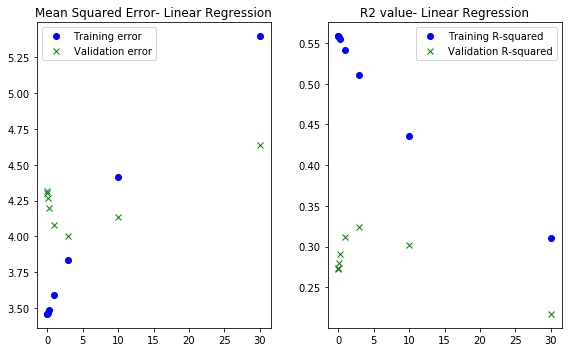

In [838]:
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.plot(lamda_values, mse_train, 'bo', label='Training error')
plt.plot(lamda_values, mse_val, 'gx', label='Validation error')
plt.title('Mean Squared Error- Linear Regression')
plt.legend()

plt.subplot(1,2,2)
plt.plot(lamda_values, r2_train, 'bo', label='Training R-squared')
plt.plot(lamda_values, r2_val, 'gx', label='Validation R-squared')
plt.legend()
plt.title('R2 value- Linear Regression')
plt.tight_layout()
plt.show()

This shows that for a lambda value of 3 the R2 value for the validation dataset is maximum. However, this is a dismal 32%. A better model needs to be found or more features need to be added to our existing model.

**2) Using Support Vector Machine for prediction**


In [839]:
from sklearn.svm import SVR

In [840]:
# Using SVR with Linear kernel
r2_train=[]
r2_val=[]
C_list= [0.03,0.1,0.3,1,3]
for c in C_list:
    model = SVR(C=c, kernel= 'linear')
    model.fit(X1_train, y_train)

    r2_train.append(r2_score(y_train,model.predict(X1_train) ))
    r2_val.append(r2_score(y_val, model.predict(X1_val)))


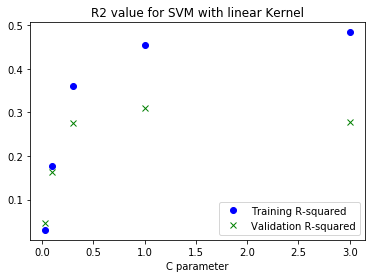

In [841]:
# PLotting the R2 value
plt.plot(C_list, r2_train, 'bo', label='Training R-squared')
plt.plot(C_list, r2_val, 'gx', label='Validation R-squared')
plt.legend()
plt.title('R2 value for SVM with linear Kernel')
plt.xlabel('C parameter')
plt.show()

The best case scenario from the SVM model is worst than linear regression model with lambda=3. We will try the gaussian kernel next to see the R2-value

In [842]:
# Using SVR with RBF/Gaussian kernel
r2_train=[]
r2_val=[]
C_list= [0.03,0.1,0.3,1,3]
for c in C_list:
    model = SVR(C=c, kernel= 'rbf',gamma= 'scale' )
    model.fit(X1_train, y_train)

    r2_train.append(r2_score(y_train,model.predict(X1_train) ))
    r2_val.append(r2_score(y_val, model.predict(X1_val)))


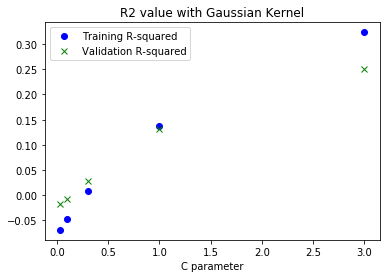

In [843]:
# PLotting the R2 value
plt.plot(C_list, r2_train, 'bo', label='Training R-squared')
plt.plot(C_list, r2_val, 'gx', label='Validation R-squared')
plt.legend()
plt.title('R2 value with Gaussian Kernel')
plt.xlabel('C parameter')
plt.show()

In [844]:
# Using SVR with polynomial kernel
r2_train=[]
r2_val=[]
C_list= [0.03,0.1,0.3,1,3]
for c in C_list:
    model = SVR(C=c, kernel= 'poly', degree=2, gamma= 'scale' )
    model.fit(X1_train, y_train)

    r2_train.append(r2_score(y_train,model.predict(X1_train) ))
    r2_val.append(r2_score(y_val, model.predict(X1_val)))


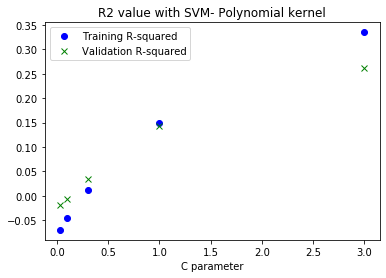

In [845]:
# PLotting the R2 value
plt.plot(C_list, r2_train, 'bo', label='Training R-squared')
plt.plot(C_list, r2_val, 'gx', label='Validation R-squared')
plt.legend()
plt.title('R2 value with SVM- Polynomial kernel')
plt.xlabel('C parameter')
plt.show()

Both the gaussian and polynomial kernels are not better predictors than the linear kernel or compared to linear regression.

Since our models are bad at predicting the completion rate, we need to extract information from the Course name and see if they help to increase the model prediction.